#### Data Import and Preprocessing

In [7]:
# Standard imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Import raw dataset
pew_data = pd.read_csv("pew_automation.csv")

# Convert to dataframe
pew_raw = pd.DataFrame(pew_data)

# Display the first few rows of the dataset
pew_raw.head()

,QKEY,NEW_Device_Type_W27,LANGUAGE_W27,FORM_W27,CAREREL_W27,INDUSTRY_W27,JOBDUTY_A_W27,JOBDUTY_B_W27,JOBDUTY_C_W27,JOBDUTY_D_W27,...,WORKCAT_62,WORKCAT_63,WORKCAT_64,WORKCAT_65,WORKCAT_66,WORKCAT_67,WORKCAT_68,WORKCAT_23,WORKCAT_99,WEIGHT_W27
0,100197.0,2.0,9.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175440
1,100260.0,2.0,9.0,2.0,3.0,7.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414386
2,100314.0,3.0,9.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.429735
3,100363.0,1.0,9.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.814315
4,100446.0,3.0,9.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162845


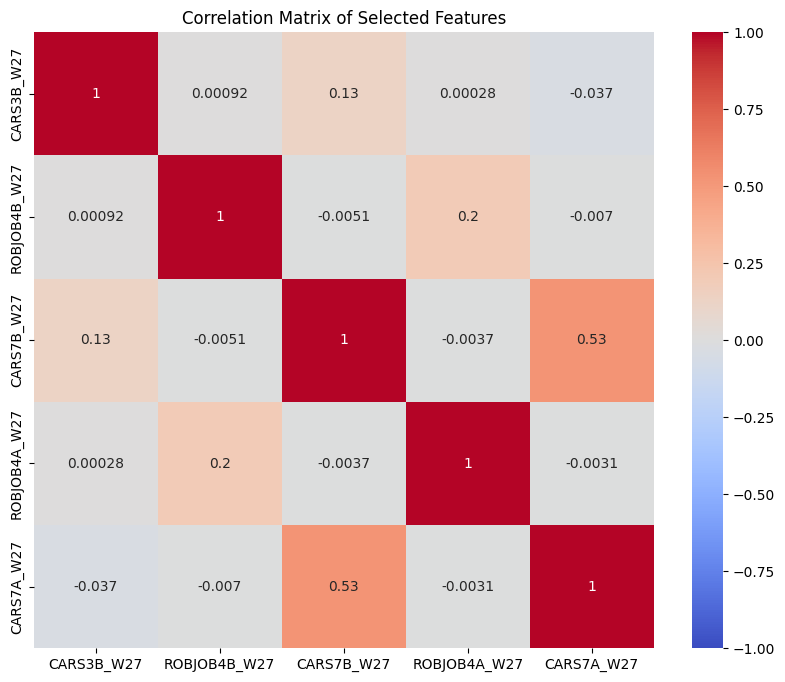

In [ ]:
# Check for multicollinearity using correlation matrix
selected_features = [
    'CARS3B_W27', 'ROBJOB4B_W27', 'CARS7B_W27', 'ROBJOB4A_W27', 'CARS7A_W27']

corr_matrix = pew_raw[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [10]:
# Replace 99 with NaN
pew_raw.replace({99: np.nan}, inplace=True)  

# Create binary Target from ROBJOB3B_W27 (How worried are you about automation) 
pew_raw['Target'] = pew_raw['ROBJOB3B_W27'].replace({1: 1, 2: 1, 3: 0, 4: 0})

# Create a new DataFrame with selected features and target variable
pew = pew_raw[['CARS3B_W27', 'ROBJOB4B_W27', 'CARS7B_W27', 'ROBJOB4A_W27', 'CARS7A_W27', 'Target']].copy()

pew.shape

(4135, 6)

In [11]:
# Drop rows with NaN values
pew_auto = pew.dropna()
pew_auto.reset_index(drop=True, inplace=True) # Reset index after dropping NaN

# Check the shape of the cleaned DataFrame
pew_auto.shape

(4061, 6)

In [12]:
# Check the distribution of the target variable
round(pew_auto['Target'].value_counts(normalize=True), 2)

Target
1.0    0.69
0.0    0.31
Name: proportion, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pew_auto.drop('Target', axis=1),
    pew_auto['Target'],
    test_size=0.3,
    random_state=42, 
    stratify=pew_auto['Target']
)

# Check the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2842, 5), (1219, 5), (2842,), (1219,))

In [14]:
# Check the distribution of the target variable in training and testing sets
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Target
 1.0    0.692822
 0.0    0.307178
 Name: proportion, dtype: float64,
 Target
 1.0    0.693191
 0.0    0.306809
 Name: proportion, dtype: float64)

In [ ]:
# Use RandomOverSampler to balance the dataset
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42, sampling_strategy="not majority")
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
pew_resampled = pd.DataFrame(X_train_res, columns=pew_auto.columns)
pew_resampled['Target'] = y_train_res

pew_resampled.shape

(3938, 6)

#### Model Training

In [19]:
# Check what the resampled DataFrame looks like
pew_resampled.head(10)

,CARS3B_W27,ROBJOB4B_W27,CARS7B_W27,ROBJOB4A_W27,CARS7A_W27,Target
0,2.0,1.0,4.0,1.0,4.0,1.0
1,3.0,2.0,2.0,2.0,2.0,0.0
2,1.0,1.0,4.0,1.0,3.0,1.0
3,2.0,2.0,3.0,1.0,2.0,1.0
4,1.0,1.0,2.0,2.0,2.0,1.0
5,3.0,2.0,3.0,2.0,3.0,0.0
6,2.0,1.0,2.0,1.0,2.0,0.0
7,4.0,1.0,4.0,1.0,4.0,1.0
8,2.0,2.0,4.0,2.0,3.0,1.0
9,2.0,1.0,4.0,2.0,3.0,1.0


In [ ]:
# Modeling training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline

# Define the models to be used
models = {
    'lst': LogisticRegression(max_iter=1000, random_state=42),
    'rfc': RandomForestClassifier(random_state=42),
    'xgb': XGBClassifier(eval_metric="logloss", random_state=42)
}

# Train and cross validate each model
for name, model in models.items():
    f1 = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='f1')
    print(f"{name}: Mean F1 score = {f1.mean():.4f}, Std F1 score = {f1.std():.4f}")
    accuracy = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {accuracy.mean():.4f}, Std Accuracy = {accuracy.std():.4f}")

# Hyperparameter tuning for RandomForestClassifier and XGBClassifier
rfc_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None], 
    'min_samples_split': [2, 5]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV for RandomForestClassifier
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42), rfc_param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_rfc.fit(X_train_res, y_train_res)

# Perform GridSearchCV for XGBClassifier
grid_xgb = GridSearchCV(XGBClassifier(eval_metric="logloss", random_state=42), xgb_param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train_res, y_train_res)

# Print the best parameters and best score for RandomForestClassifier
print("Best parameters for RandomForestClassifier:", grid_rfc.best_params_)    
print("Best F1 score for RandomForestClassifier:", grid_rfc.best_score_)
# Print the best parameters and best score for XGBClassifier
print("Best parameters for XGBClassifier:", grid_xgb.best_params_)
print("Best F1 score for XGBClassifier:", grid_xgb.best_score_)

# Evaluate the best models on the test set
best_models = {
    'LogisticRegression': models['lst'].fit(X_train_res, y_train_res),
    'RandomForest (Tuned)': grid_rfc.best_estimator_, 
    'XGBoost (Tuned)': grid_xgb.best_estimator_
}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC", roc_auc_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

lst: Mean F1 score = 0.7129, Std F1 score = 0.0073
lst: Mean Accuracy = 0.6986, Std Accuracy = 0.0108
rfc: Mean F1 score = 0.7087, Std F1 score = 0.0127
rfc: Mean Accuracy = 0.7034, Std Accuracy = 0.0119
xgb: Mean F1 score = 0.7109, Std F1 score = 0.0081
xgb: Mean Accuracy = 0.7070, Std Accuracy = 0.0104
Best parameters for RandomForestClassifier: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score for RandomForestClassifier: 0.7095983118792724
Best parameters for XGBClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best F1 score for XGBClassifier: 0.7218316856665347
Model: LofisticRegression
Accuracy: 0.7260049220672683
F1 Score: 0.7978208232445521
ROC AUC 0.692079865835522
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.60      0.58       374
         1.0       0.82      0.78      0.80       845

    accuracy                           0.73      1219
   macro a

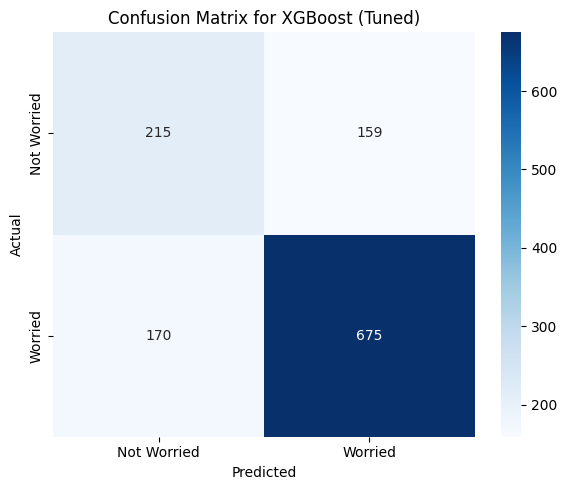

In [ ]:
# Plot confusion matrix for the best model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get predictions from the best XGBoost model
xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Worried', 'Worried'],
            yticklabels=['Not Worried', 'Worried'])
plt.title('Confusion Matrix for XGBoost (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

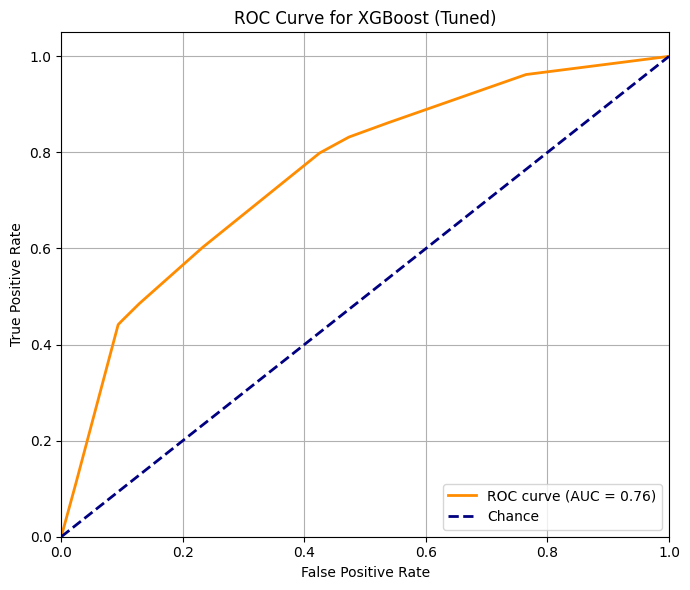

In [ ]:
# Plot ROC curve for the best XGBoost model
from sklearn.metrics import roc_curve, auc

# Predict probabilities for XGBoost model
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (Tuned)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Save Best Model

In [18]:
import joblib
joblib.dump(best_models['XGBoost (Tuned)'], 'best_xgb_model.pkl')

['best_xgb_model.pkl']